## This is a notebook for the Vector processing in Python session

After learning how to create and load geodata in python, let's do some typical vector data processing that are required in almost every GIS project.

You will be introduced to how to:

- to Deal with different projections
- to Reclassify your data based on different criteria
- to Do queries and subsetting 
- to do Spatial overlays 


# Map projections

Shapefiles contain information about the coordinate reference system that is stored in `.prj` -file (if the data has been appropriately produced). When reading the data into GeoDataFrame with Geopandas this information is automatically stored into `.crs` of the GeoDataFrame.
Let’s read Europe_borders.shp file and checking the crs:

In [1]:
#let's download a file containting European borders
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

#the data is from EEA 
zipurl ='https://github.com/jimjoker/Geospatial-Analysis-Notebooks/raw/master/Data2.zip'
with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall('Data')


In [ ]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

/var/folders/3q/rdvr784x4j187z430xxs1w0h0000gn/T/ipykernel_41589/319504150.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
Duplicate key in file '/Users/jamal/.matplotlib/matplotlibrc', line 2 ('backend: TkAgg')
Duplicate key in file '/Users/jamal/.matplotlib/matplotlibrc', line 3 ('backend: TkAgg')
Duplicate key in fil

projection is: EPSG:4326


0    POLYGON ((8.45778 54.56236, 8.44953 54.56269, ...
1    POLYGON ((8.71992 47.69664, 8.72092 47.69530, ...
2    POLYGON ((6.73317 53.57409, 6.73017 53.57542, ...
3    POLYGON ((6.85822 53.59411, 6.85592 53.59550, ...
4    POLYGON ((6.89894 53.62561, 6.88439 53.62814, ...
Name: geometry, dtype: geometry

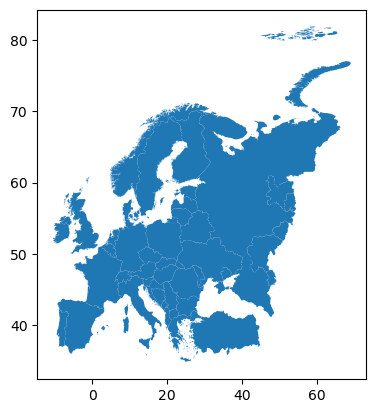

In [2]:
import geopandas as gpd
# Read the file 
fp = "Data/Data2/Europe_borders.shp" 


data = gpd.read_file(fp) 
data.plot()

# Check the details of the coordinate reference system. It's "WGS84", EPSG:4326
print("projection is:", data.crs)

data['geometry'].head()
#the crs is a Python dictionary with a key init that has a value epsg:4326. This is a very typical way how CRS is stored in GeoDataFrames. 


Let’s continue by checking the values in our ``geometry`` -column to verify that the CRS of our GeoDataFrame is correct: (note that the units are not decimal degress, it is metric)

In [3]:
data['geometry'].head() 

0    POLYGON ((8.45778 54.56236, 8.44953 54.56269, ...
1    POLYGON ((8.71992 47.69664, 8.72092 47.69530, ...
2    POLYGON ((6.73317 53.57409, 6.73017 53.57542, ...
3    POLYGON ((6.85822 53.59411, 6.85592 53.59550, ...
4    POLYGON ((6.89894 53.62561, 6.88439 53.62814, ...
Name: geometry, dtype: geometry

WGS84 projection is not really a good one for representing European borders, so let’s convert those geometries  from Lambert Azimuthal Equal Area projection (EPSG: 3035), which is the recommended projection by European Comission, to WGS84 (EPSG:4326) to see the diffrences of the two projections.
Let’s re-project our data into EPSG 3035 using ``epsg`` -parameter:


In [4]:
# Let's make a copy of our data 
orig = data.copy() 

# Reproject the data 
data = data.to_crs("EPSG:3035") 


# Check the new geometry values 
print(data['geometry'].head())

0    POLYGON ((4221214.558 3496203.404, 4220681.651...
1    POLYGON ((4224860.478 2732279.320, 4224932.819...
2    POLYGON ((4104652.176 3390034.953, 4104460.401...
3    POLYGON ((4113025.664 3391895.756, 4112879.943...
4    POLYGON ((4115871.228 3395282.099, 4114921.348...
Name: geometry, dtype: geometry


Let’s compare the datasets by making maps out of them.


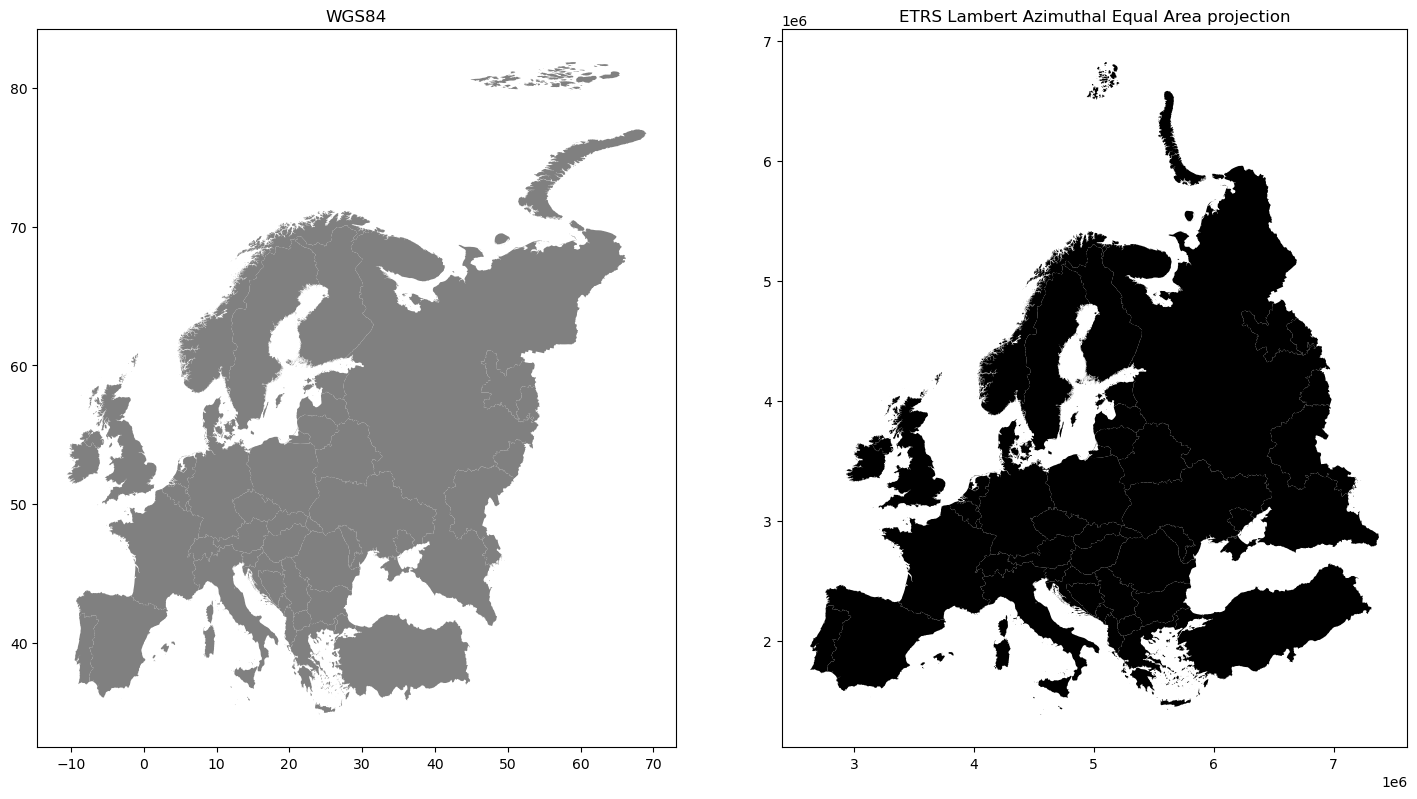

In [5]:
%matplotlib inline 
import matplotlib.pyplot as plt 

# Make subplots that are next to each other 
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8)) 

# Plot the data in ETRS-LAEA projection  
orig.plot(ax=ax1, facecolor='gray')

# Add title 
ax1.set_title("WGS84")

# Plot the one with WGS84 CRS 
data.plot(ax=ax2, facecolor='black')

# Add title 
ax2.set_title("ETRS Lambert Azimuthal Equal Area projection")

# Remove empty white space around the plot 
plt.tight_layout()


You can visually comapre the two maps and see how distances and areas get distorted across the entire area. 

Let's export the re-projected data!

In [6]:
# Ouput filepath 
outfp = "Europe_borders_epsg3035.shp" 
# Save to disk 
data.to_file(outfp)


# Calculating distances

The aim is to find the Euclidean distances from the centroids of all European countries to Copenhagen using a metric projection (`Azimuthal Equidistan` -projection) in meters. 
Let’s first create a GeoDataFrame that contains a single Point representing the location of CPH:


In [7]:
# Import necessary modules 
from shapely.geometry import Point 
import pycrs 
# Create the point representing CPH (in WGS84) 
cph_lon = 12.5683 
cph_lat = 55.6761 
# Create GeoDataFrame 
copenhagen = gpd.GeoDataFrame([[Point(cph_lon, cph_lat)]], geometry='geometry', crs='epsg:4326', columns=['geometry']) 
# Print 
print(copenhagen)


                    geometry
0  POINT (12.56830 55.67610)


In [8]:
# Import pyproj 
import pyproj 

# Define the projection using the coordinates of our CPH point (cph_lat, cph_lon) as the center point 
# The .srs here returns the Proj4-string presentation of the projection 
aeqd = pyproj.Proj(proj='aeqd', ellps='WGS84', datum='WGS84', lat_0=cph_lat, lon_0=cph_lon).srs

# Reproject to aeqd projection using Proj4-string 
copenhagen = copenhagen.to_crs(crs=aeqd) 

# Print the data 
print(copenhagen) 
# Print the crs 
print("\nCRS:\n", copenhagen.crs)


              geometry
0  POINT (0.000 0.000)

CRS:
 +proj=aeqd +lat_0=55.6761 +lon_0=12.5683 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs


Next we want to transform the Europe_borders.shp data into the desired projection.

Let’s create a new copy of our GeoDataFrame into a variable called europe_borders_aeqd:


In [9]:
# Create a copy 
europe_borders_aeqd = data.copy() 


Let’s now reproject our Europe borders data into the Azimuthal Equidistant projection that was centered into Copenhagen:


In [10]:
# Reproject to aeqd projection that we defined earlier 
europe_borders_aeqd = europe_borders_aeqd.to_crs(crs=aeqd) 

# Print 
print(europe_borders_aeqd.head(2))


            TZID                                           geometry
0  Europe/Berlin  POLYGON ((-265767.784 -116145.805, -266298.416...
1  Europe/Berlin  POLYGON ((-289664.907 -880020.175, -289597.694...


Let’s plot the Europe borders and the location of CPH to get a better understanding how our projection has worked out:


<Axes: >

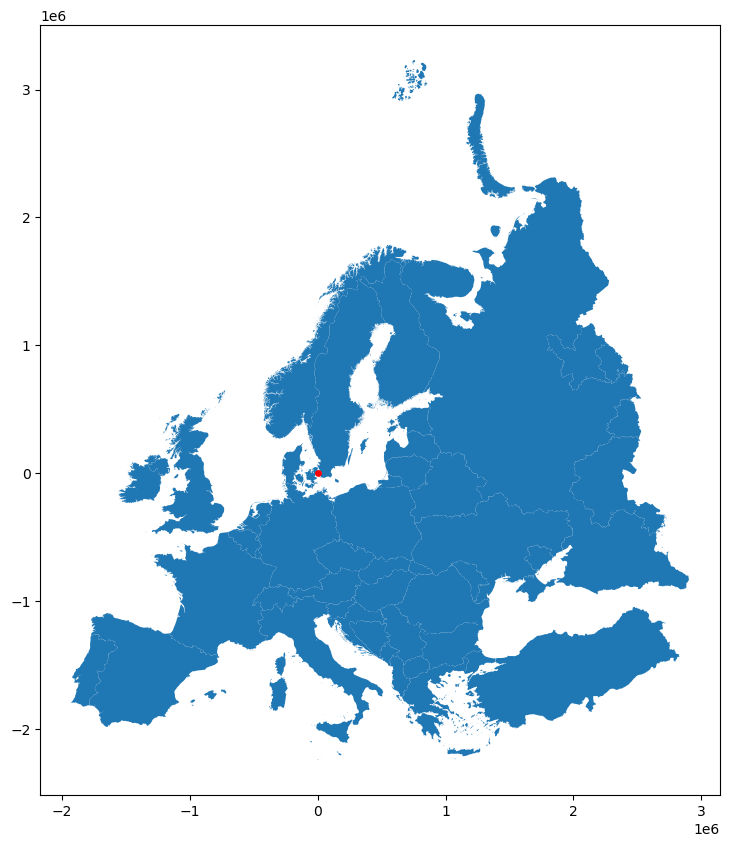

In [11]:
%matplotlib inline 
fig, ax = plt.subplots(figsize=(10,10)) 

# Plot the country borders 
europe_borders_aeqd.plot(ax=ax) 

# Plot the Copenhagen point on top of the borders using the same axis 
copenhagen.plot(ax=ax, color='red', markersize=15)


Our goal is to calculate the distance from all countries to Copenhagen. So, we need to calculate the centroids for all the Polygons representing the boundaries of European countries.
This can be done easily in Geopandas by using the ``centroid`` attribute:


In [12]:
europe_borders_aeqd['centroid'] = europe_borders_aeqd.centroid 
print(europe_borders_aeqd.head(5))


            TZID                                           geometry   
0  Europe/Berlin  POLYGON ((-265767.784 -116145.805, -266298.416...  \
1  Europe/Berlin  POLYGON ((-289664.907 -880020.175, -289597.694...   
2  Europe/Berlin  POLYGON ((-386180.530 -217870.352, -386366.382...   
3  Europe/Berlin  POLYGON ((-377742.268 -216330.814, -377881.941...   
4  Europe/Berlin  POLYGON ((-374772.593 -213053.896, -375710.006...   

                          centroid  
0  POINT (-266175.354 -114901.046)  
1  POINT (-291644.406 -879209.307)  
2  POINT (-386367.715 -215132.212)  
3  POINT (-377219.999 -215786.937)  
4  POINT (-374875.882 -211246.954)  


First, we will create a dedicated function for calculating the distances called ``calculate_distance()``:


In [13]:
def calculate_distance(row, dest_geom, src_col='geometry', target_col='distance'):
    """
    Calculates the distance between Point geometries.
    Parameters
    ----------
    dest_geom : shapely.Point
       A single Shapely Point geometry to which the distances will be calculated to.
    src_col : str
       A name of the column that has the Shapely Point objects from where the distances will be calculated from.
    target_col : str
       A name of the target column where the result will be stored.
    Returns
    -------
    Distance in kilometers that will be stored in 'target_col'.
    """
    # Calculate the distances
    dist = row[src_col].distance(dest_geom)

    # Convert into kilometers
    dist_km = dist / 1000

    # Assign the distance to the original data
    row[target_col] = dist_km
    return row


Before using our function and calculating the distances between Copenhagen and centroids, we need to get the Shapely point geometry from the re-projected Copenhagen center point that we can pass to our function (into the ``dest_geom`` -parameter. We can use the ``loc`` -functionality to retrieve the value from specific index and column:


In [14]:
# Retrieve the geometry from Copenhagen GeoDataFrame 
copenhagen_geom = copenhagen.loc[0, 'geometry'] 

print(copenhagen_geom)


POINT (0 0)


When iterating over a GeoDataFrame, apply function is used like this
GeoDataFrame.apply(name_of_your_function, param1, param2, param3,  axis=1)

In [15]:
# Calculate the distances using our custom function called 'calculate_distance’ 
europe_borders_aeqd = europe_borders_aeqd.apply(calculate_distance, 
    dest_geom=copenhagen_geom, src_col='centroid', target_col='dist_to_cph', axis=1) 

print(europe_borders_aeqd.head(10))


            TZID                                           geometry   
0  Europe/Berlin  POLYGON ((-265767.784 -116145.805, -266298.416...  \
1  Europe/Berlin  POLYGON ((-289664.907 -880020.175, -289597.694...   
2  Europe/Berlin  POLYGON ((-386180.530 -217870.352, -386366.382...   
3  Europe/Berlin  POLYGON ((-377742.268 -216330.814, -377881.941...   
4  Europe/Berlin  POLYGON ((-374772.593 -213053.896, -375710.006...   
5  Europe/Berlin  POLYGON ((-365936.074 -207995.191, -368515.106...   
6  Europe/Berlin  POLYGON ((-356521.295 -203999.363, -355026.882...   
7  Europe/Berlin  POLYGON ((-322527.027 -202479.785, -322770.396...   
8  Europe/Berlin  POLYGON ((-302517.766 -201254.355, -303037.663...   
9  Europe/Berlin  POLYGON ((112297.264 -218285.166, 111935.089 -...   

                                          centroid  dist_to_cph  
0   POINT (-266175.3535691544 -114901.04635844329)   289.916487  
1   POINT (-291644.40614494414 -879209.3068141427)   926.318231  
2   POINT (-386367.7

In [16]:
data.head(3)

,TZID,geometry
0,Europe/Berlin,"POLYGON ((4221214.558 3496203.404, 4220681.651..."
1,Europe/Berlin,"POLYGON ((4224860.478 2732279.320, 4224932.819..."
2,Europe/Berlin,"POLYGON ((4104652.176 3390034.953, 4104460.401..."


Let’s check what is the longest and mean distance to Copenhagen from the centroids of other European countries:


In [17]:
# Calculate the maximum and average distance 
max_dist = europe_borders_aeqd['dist_to_cph'].max() 
mean_dist = europe_borders_aeqd['dist_to_cph'].mean() 

print("Maximum distance to Copenhagen is %.0f km, and the mean distance is %.0f km." % (max_dist, mean_dist))


Maximum distance to Copenhagen is 3306 km, and the mean distance is 1205 km.


# Geometric operations: Overlay analysis

The aim is to make an overlay analysis where we create a new layer based on geometries from a dataset that intersect with geometries of another layer. 
Here, we are going to clip land use features from `dk001l_kobenhavn.shp` within a box `CPH_Box.shp`

Here is a set of functions for overlay analysis.
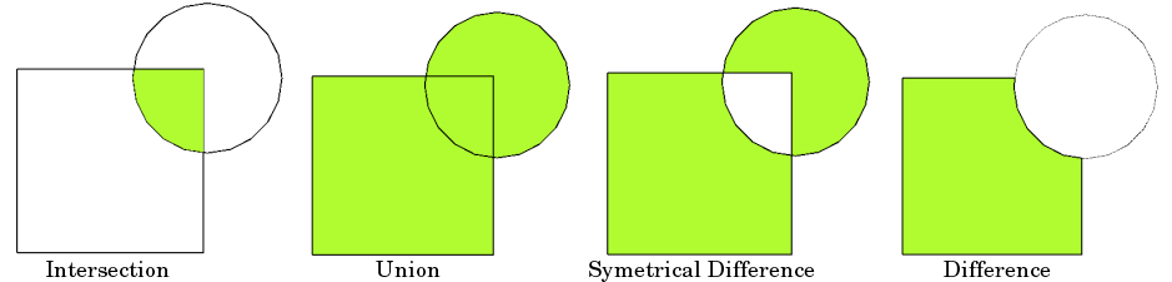




/var/folders/3q/rdvr784x4j187z430xxs1w0h0000gn/T/ipykernel_41589/1838070929.py:7: DeprecationWarning: This function has no longer any effect, and will be removed in a future release. Starting with Shapely 2.0, equivalent speedups are always available
  shapely.speedups.enable()


<Axes: >

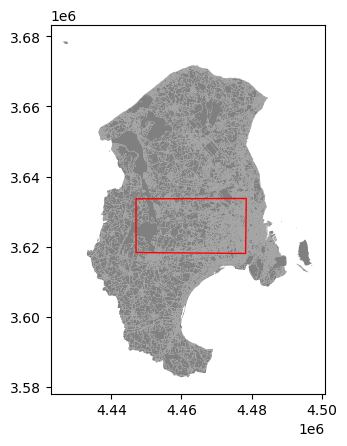

In [18]:
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.speedups
%matplotlib inline

# Let's enable speedups to make queries faster
shapely.speedups.enable()

# File paths, make sure you know where you data is 
border_fp = "Data/Data2/CPH_Box.shp"
grid_fp = "Data2/dk001l_kobenhavn/dk001l_kobenhavn.shp"

# Read files
grid = gpd.read_file(grid_fp)
hel = gpd.read_file(border_fp)

# Plot the layers
ax = grid.plot(facecolor='grey')
hel.plot(ax=ax, facecolor='None', edgecolor='red')

Here the red area is the borders that we want to use for conducting the overlay analysis and select the geometries from the Polygon grid.
Always, when conducting GIS operations involving multiple layers, it is required to check that the CRS of the layers match:



In [19]:
# Ensure that the CRS matches, if not raise an AssertionError 
assert hel.crs == grid.crs, "CRS differs between layers!"

AssertionError: CRS differs between layers!

let's reproject the ``hel`` geodataframe into the same projection as ``grid``is in


In [20]:
hel_new = hel.to_crs(grid.crs)

Let’s do an overlay analysis and create a new layer from polygons of the grid that intersect with our CPH layer. 

We can use a function called ``overlay()`` to conduct the overlay analysis that takes inputs like
- the GeoDataFrame where the selection is taken, 
- the GeoDataFrame used for making the selection, and 
- parameter how that can be used to control how the overlay analysis is conducted (possible values are `intersection`, `union`, `symmetric_difference`, `difference`, and `identity`).

In [21]:
intersection = gpd.overlay(grid, hel_new, how='intersection')

Let’s plot it!


<Axes: >

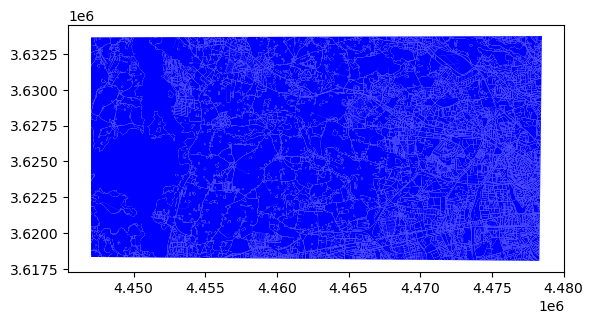

In [22]:
intersection.plot(color="b") 

Let's check whether the attributes are also there!

In [23]:
print(intersection.head()) 

      CITIES LUZ_OR_CIT   CODE   
0  Kobenhavn     DK001L  11210  \
1  Kobenhavn     DK001L  11100   
2  Kobenhavn     DK001L  11100   
3  Kobenhavn     DK001L  11100   
4  Kobenhavn     DK001L  11100   

                                                ITEM PROD_DATE    SHAPE_LEN   
0  Discontinuous Dense Urban Fabric (S.L. : 50% -...      2009  2255.312254  \
1               Continuous Urban Fabric (S.L. > 80%)      2009   196.603728   
2               Continuous Urban Fabric (S.L. > 80%)      2009  1429.773631   
3               Continuous Urban Fabric (S.L. > 80%)      2009   230.394197   
4               Continuous Urban Fabric (S.L. > 80%)      2009  1041.743721   

     SHAPE_AREA  id                                           geometry  
0  41843.463250 NaN  POLYGON ((4458200.568 3631330.861, 4458144.795...  
1   1135.020617 NaN  POLYGON ((4473231.226 3618261.729, 4473213.238...  
2  23871.052402 NaN  POLYGON ((4475426.301 3618383.392, 4475371.511...  
3   1246.329702 NaN  POLYGON

==>

Let’s save our result grid as a GeoJSON file that is commonly used file format nowadays for storing spatial data.


In [24]:
# Output filepath 
outfp = "CPH_LU_Box.geojson" 

# Use ESRI Shapefile driver 
intersection.to_file(outfp, driver='GeoJSON')

You can see what data formats `Fiona` supports  

In [25]:
import fiona
fiona.supported_drivers

{'DXF': 'rw',
 'CSV': 'raw',
 'OpenFileGDB': 'raw',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'FlatGeobuf': 'raw',
 'GeoJSON': 'raw',
 'GeoJSONSeq': 'raw',
 'GPKG': 'raw',
 'GML': 'rw',
 'OGR_GMT': 'rw',
 'GPX': 'rw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'raw',
 'OGR_PDS': 'r',
 'S57': 'r',
 'SQLite': 'raw',
 'TopoJSON': 'r'}

### Notice:
if your dataset contains multipart objects, you will have to convert them into single object features.

So, in that case you will have to run the following function on your dataset.


In [26]:
#import fiona
#from shapely import geometry
#upcast_dispatch = {geometry.Point: geometry.MultiPoint, 
#                  geometry.LineString: geometry.MultiLineString, 
#                  geometry.Polygon: geometry.MultiPolygon}

#def maybe_cast_to_multigeometry(geom):
#    caster = upcast_dispatch.get(type(geom), lambda x: x[0])
#    return caster([geom])
#intersection2=intersection.geometry.apply(maybe_cast_to_multigeometry)

#### What's next? Aggregation

Aggregation means merging Geometries together by some common identifier. Suppose we are interested in studying continents, but we only have country-level data like the country dataset. By aggregation we would convert this into a continent-level dataset.

Here, we will aggregate our land use data by type (column `ITEM`), i.e. the grid cells that have the same land type will be dissolved.

For doing the aggregation we will use a function called ``dissolve()``.

In [27]:
# Conduct the aggregation 
dissolved = intersection.dissolve(by="ITEM") 
# What did we get 
print(dissolved.head())

                                                                                             geometry   
ITEM                                                                                                    
Agricultural + Semi-natural areas + Wetlands        MULTIPOLYGON (((4447913.435 3618337.630, 44479...  \
Airports                                            POLYGON ((4467437.948 3632515.528, 4467438.459...   
Construction sites                                  MULTIPOLYGON (((4461493.070 3618210.194, 44615...   
Continuous Urban Fabric (S.L. > 80%)                MULTIPOLYGON (((4462481.581 3618255.090, 44624...   
Discontinuous Dense Urban Fabric (S.L. : 50% - ...  MULTIPOLYGON (((4452829.560 3618304.415, 44528...   

                                                       CITIES LUZ_OR_CIT   
ITEM                                                                       
Agricultural + Semi-natural areas + Wetlands        Kobenhavn     DK001L  \
Airports                            

Let’s compare the number of cells in the layers before and after the aggregation:


In [28]:
print('Rows in original intersection GeoDataFrame:', len(intersection))
print('Rows in dissolved layer:', len(dissolved))


Rows in original intersection GeoDataFrame: 7169
Rows in dissolved layer: 20


What happend? ===>

In [29]:
print(dissolved.columns) 

Index(['geometry', 'CITIES', 'LUZ_OR_CIT', 'CODE', 'PROD_DATE', 'SHAPE_LEN',
       'SHAPE_AREA', 'id'],
      dtype='object')


As we can see, the column that we used for conducting the aggregation (ITEM) can not be found from the columns list anymore. What happened to it?

It is now used as index in our dissolved GeoDataFrame.


In [30]:
print(dissolved.index) 

Index(['Agricultural + Semi-natural areas + Wetlands', 'Airports',
       'Construction sites', 'Continuous Urban Fabric (S.L. > 80%)',
       'Discontinuous Dense Urban Fabric (S.L. : 50% -  80%)',
       'Discontinuous Low Density Urban Fabric (S.L. : 10% - 30%)',
       'Discontinuous Medium Density Urban Fabric (S.L. : 30% - 50%)',
       'Discontinuous Very Low Density Urban Fabric (S.L. < 10%)',
       'Fast transit roads and associated land', 'Forests',
       'Green urban areas',
       'Industrial, commercial, public, military and private units',
       'Isolated Structures', 'Land without current use',
       'Mineral extraction and dump sites', 'Other roads and associated land',
       'Port areas', 'Railways and associated land',
       'Sports and leisure facilities', 'Water bodies'],
      dtype='object', name='ITEM')


Now, we can f.x. select only such geometries from the layer that are namely ”Green urban areas” :


In [31]:
# Select only geometries that are Green urban areas
sel_green = dissolved.iloc[15] 
# See the data type 
print(type(sel_green)) 
# See the data 
print(sel_green.head())


<class 'pandas.core.series.Series'>
geometry      MULTIPOLYGON (((4462497.436640464 3618197.7364...
CITIES                                                Kobenhavn
LUZ_OR_CIT                                               DK001L
CODE                                                      12220
PROD_DATE                                                  2009
Name: Other roads and associated land, dtype: object


In [32]:
# Select only geometries that are Green urban areas
sel_green = dissolved.loc['Green urban areas'] 
# See the data type 
print(type(sel_green)) 
# See the data 
print(sel_green.head())



<class 'pandas.core.series.Series'>
geometry      MULTIPOLYGON (((4458183.425439802 3618233.0511...
CITIES                                                Kobenhavn
LUZ_OR_CIT                                               DK001L
CODE                                                      14100
PROD_DATE                                                  2009
Name: Green urban areas, dtype: object


Now, we have a ``Pandas`` Series object containing basically one row from our original aggregated GeoDataFrame. Let’s convert the Series into GeoDataFrame and plot it to see where those green areas are located:


<Axes: >

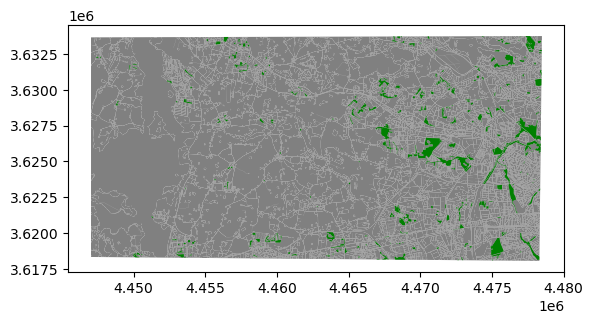

In [33]:
# Create a GeoDataFrame 
geo = gpd.GeoDataFrame([sel_green.values], crs=dissolved.crs, columns=dissolved.columns) 

# Plot the grid cells that are green
ax = dissolved.plot(facecolor='grey') 
geo.plot(ax=ax, facecolor='green')


## 🏋 Exercise

Select `Industrial, commercial, public, military and private units` geometries and plot them. Add your code below!